In [139]:
# Tanisha Gosain

# This is a Google Colab Python vesion for 
# Image super-resolution using Plug-and-play ADMM

# The code has been inspired by the following repository:
# https://www.mathworks.com/matlabcentral/fileexchange/60641-plug-and-play-admm-for-image-restoration

In [140]:
!pip install bm3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [141]:
import cv2
import numpy as np
import random
import scipy.ndimage
import scipy.signal
from matplotlib import pyplot as plt
import bm3d
import math
from skimage.restoration import denoise_nl_means

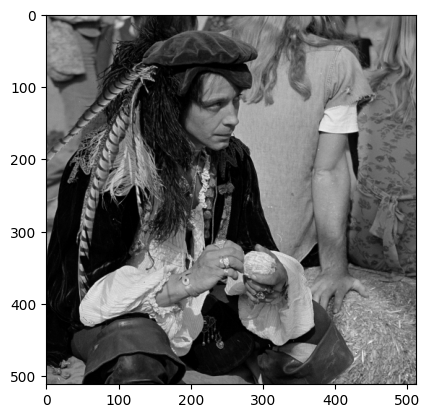

In [214]:
# read test image
img = cv2.imread('Man512.png',cv2.IMREAD_GRAYSCALE)
# z = img
z = cv2.normalize(img.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
plt.imshow(z, cmap='gray')
plt.show()

In [215]:
# https://stackoverflow.com/questions/17190649/how-to-obtain-a-gaussian-filter-in-python
def matlab_style_gauss2D(shape=(9,9),sigma=1):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h
# print(matlab_style_gauss2D(shape=(9,9),sigma=1))

In [216]:
# Make MATLAB style blur filter
# size_filter = 9
# sigma = 1
# testimg = np.zeros((size_filter,size_filter))
# testimg[4,4] = 1
# h = cv2.GaussianBlur(testimg, (size_filter,size_filter), sigma, sigma)
h = matlab_style_gauss2D(shape=(9,9),sigma=1)
#np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
# print(h)

In [217]:
# downsampling factor
K = 2
noise_level = 10/255
random.seed(0)


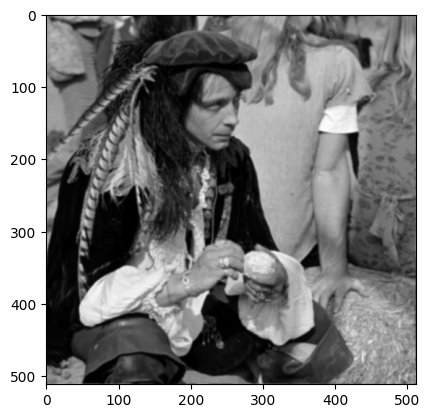

In [218]:
# calculate observed image
# first, convolve with blur filter
y = scipy.ndimage.correlate(z, h, mode='wrap')
plt.imshow(y, cmap='gray')
plt.show()

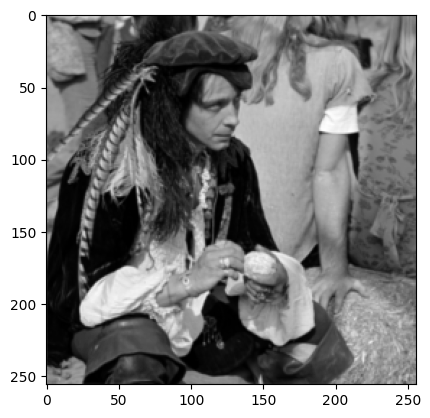

In [219]:
# Downsampling
y_rowdown = y[::K]
y_coldown = y_rowdown.transpose()[::K]
y_downsampled = y_coldown.transpose()
# print(y_downsampled.shape)
plt.imshow(y_downsampled, cmap='gray')
plt.show()
y = y_downsampled

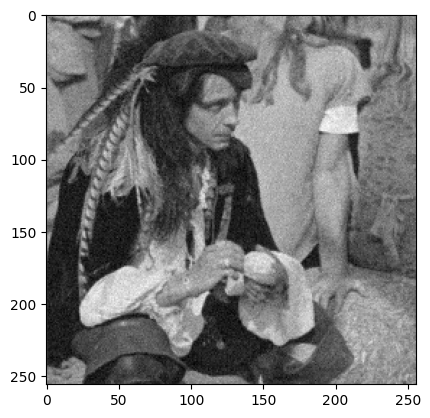

In [220]:
# Add noise
gauss = np.random.normal(0,noise_level,(y.shape))
gauss = gauss.reshape(y.shape)
y_noisy = y + gauss
plt.imshow(y_noisy, cmap='gray')
plt.show()

<ipython-input-152-3e339039991b>:7: ComplexWarning: Casting complex values to real discards the imaginary part
  new_x[i*K][j*K] = x[i][j]


24.759785654622817


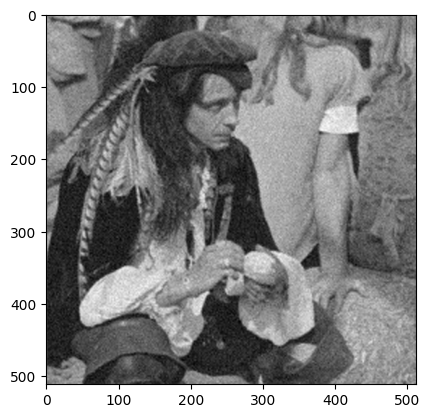

In [221]:
## BEFORE RUNNING THIS, MAKE SURE TO RUN ALL FUNCTIONS CELLS BELOW

method = 'BM3D';
if method == 'RF':
  lambd = 0.0002
elif method == 'NLM':
  lambd = 0.001
elif method == 'BM3D':
  lambd = 0.001
elif method == 'TV':
  lambd = 0.01
opts = {}
opts['rho'] = 1
opts['gamma'] = 1
opts['max_iter'] = 1
opts['tol'] = 1e-4
num_points = 10
# tol_vec = np.logspace(-6,-1,num_points)
# rho_vec = np.logspace(0,-4,num_points)
# PSNR_vec = np.zeros((num_points,1))
# for i in range(num_points):
#   print(rho_vec[i])
#   opts['rho'] = rho_vec[i]
#   out = PlugPlayADMM_super(y_noisy, h, K, lambd, opts)
#   PSNR_out = psnr(out, z)
#   PSNR_vec[i] = PSNR_out

# print(PSNR_vec)
out = PlugPlayADMM_super(y_noisy, h, K, lambd, opts)
PSNR_out = psnr(out,z)


print(PSNR_out)
plt.imshow(out, cmap='gray')
plt.show()

In [97]:
np.save('Cameraman_rho_psnr',PSNR_vec)
chk = np.load('Cameraman_rho_psnr.npy')
print(chk)

[[24.1458573 ]
 [24.64189317]
 [25.15464006]
 [25.2932276 ]
 [24.63306299]
 [23.35554557]
 [21.76057883]
 [20.3535194 ]
 [19.61158919]
 [19.31307425]]


In [149]:
def PlugPlayADMM_super(y, h, K, lambd, opts):

  # set parameters
  max_iter = opts['max_iter']
  tol = opts['tol']
  gamma = opts['gamma']
  rho = opts['rho']

  # initialize variables
  rc      = y.shape
  rows_in = rc[0]
  cols_in = rc[1]
  rows    = rows_in * K
  cols    = cols_in * K
  N       = rows*cols

  # G = fdown(x, h, K)
  h_aux    = h
  K_aux    = K
  Gty      = upf(y, h_aux, K_aux)
  GGt      = constructGGt(h, K, rows, cols)
  # print(GGt[:,109])
  # print(GGt.shape)
  dim_resize = (2*y.shape[0], 2*y.shape[1])
  v        = cv2.resize(y,dim_resize, interpolation=cv2.INTER_CUBIC)  
  x        = v
  u        = np.zeros((v.shape))
  residual = np.Inf

  # set function handle for denoiser
  # TO-DO

  iter = 1
  while(residual > tol and iter <= max_iter):
    # store x, v, u from previous iterations
    x_old = x
    v_old = v
    u_old = u

    # inversion step
    xtilde = v - u
    rhs = Gty + rho*xtilde
    h_aux2 = h
    K_aux2 = K
    Grhs = fdown(rhs, h_aux2, K_aux2)
    in_nr = np.fft.fft2(Grhs)
    in_dr = GGt + rho
    in_upf = np.fft.ifft2(np.divide(in_nr, in_dr))
    h_aux3 = h
    K_aux3 = K
    x = (rhs - upf(in_upf, h_aux3, K_aux3))/rho

    # denoising step
    vtilde = x+u
    lo = 0.0
    hi = 1.0
    vtilde = proj(vtilde, lo, hi)
    sgma = np.sqrt(lambd/rho)
    v = bm3d.bm3d(vtilde, sigma_psd = sgma, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
    # v = denoise_nl_means(vtilde, sigma = sgma)
    
    # update langrangian multiplier
    u = u + (x-v)

    # update rho
    rho =  rho*gamma

    # calculate residual
    residualx = (1/np.sqrt(N))*(np.sqrt(np.sum(np.sum((x-x_old)**2))))
    residualv = (1/np.sqrt(N))*(np.sqrt(np.sum(np.sum((v-v_old)**2))))
    residualu = (1/np.sqrt(N))*(np.sqrt(np.sum(np.sum((u-u_old)**2))))

    residual = residualx + residualv + residualu
    # print(residual)
    iter = iter + 1

  return x





In [150]:
def fdown(x,h,K):
  tmp = scipy.ndimage.correlate(x, h, mode='wrap')
  tmp_rowdown = tmp[::K]
  tmp_coldown = tmp_rowdown.transpose()[::K]
  tmp_downsampled = tmp_coldown.transpose()  
  y = tmp_downsampled
  return y

In [151]:
def upf(x,h,K):
  tmp = upsample(x, K)
  y = scipy.ndimage.correlate(tmp, h, mode='wrap')
  return y

  

In [152]:
def upsample(x, K):
  sz = x.shape
  new_sz = len(x)*(K)
  new_x = np.zeros((new_sz, new_sz))
  for i in range(sz[0]):
    for j in range(sz[1]):
      new_x[i*K][j*K] = x[i][j]
  return new_x

In [153]:
def constructGGt(h, K, rows, cols):
  hth = scipy.signal.convolve2d(h, np.rot90(h,2))
  
  yc = np.ceil(hth.shape[0]/2)
  xc = np.ceil(hth.shape[1]/2)
  xc = int(xc)
  yc = int(yc)
  
  L = np.floor(hth.shape[0]/K)
  L = int(L)
  
  g = np.zeros((L,L))
  R = np.floor(L/2)
  R = int(R)
  
  for i in range(-R,R):
    for j in range(-R,R):
      g[i+R][j+R] = hth[yc+(K*i)-1][xc+(K*j)-1]
  GGt = np.absolute(np.fft.fft2(g,[int(rows/K), int(cols/K)]))
  return GGt

In [154]:
# everything less than b1 set to b1
# everything greater than b2 set to b2
def proj(x, b1, b2):
  sz = x.shape
  M = sz[0]
  N = sz[1]

  for i in range(M):
    for j in range(N):
      if(x[i][j] < b1):
        x[i][j] = b1
      elif(x[i][j] > b2):
        x[i][j] = b2
  return x

In [155]:
def  psnr(x,y):
    out = -10*math.log10( np.mean( (x.flatten()-y.flatten())**2 ) )
    return out

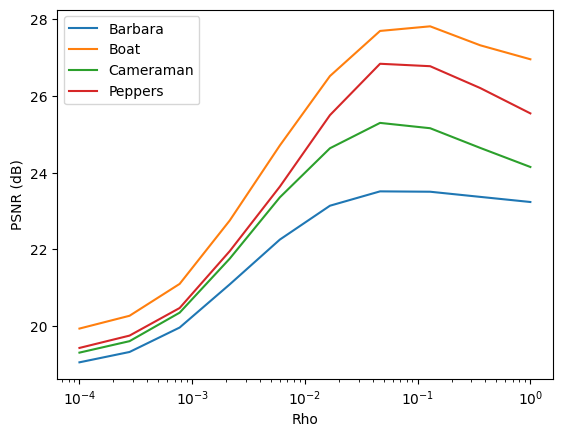

In [98]:
# vec1 = np.load('Barbara_rho_psnr.npy')
# vec2 = np.load('Boat_rho_psnr.npy')
# vec3 = np.load('Cameraman_rho_psnr.npy')
# vec4 = np.load('pepper_rho_psnr.npy')

# plt.semilogx(rho_vec,vec1)
# plt.semilogx(rho_vec,vec2)
# plt.semilogx(rho_vec,vec3)
# plt.semilogx(rho_vec,vec4)
# plt.legend(['Barbara','Boat','Cameraman','Peppers'])
# plt.xlabel('Rho')
# plt.ylabel('PSNR (dB)')
# plt.show()